First, install `mcstasscript` with `pip`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mcstasscript.interface import instr,plotter,functions,reader
import os

Cases:
- `MCPL_samples`: using `samples.mcpl.gz` without smearing
- `MCPL_resampled`: using `resampled.mcpl.gz` without smearing 
- `KDS_samples`: using `source.xml` without kde
- `KDS_resampled`: using `source.xml` with kde
- `KDS_old`: using `source.xml` with kde (original component)

Compilers:
- `gcc`: without MPI
- `mpicc`: with MPI

`McStas` versions:
- 2.7.2
- 3.2

In [2]:
# MCSTASVERSION = '2.7.2'
MCSTASVERSION = '3.2'
COMPILERS = ['gcc', 'mpicc']
CASES = ['MCPL_samples', 'MCPL_resampled', 'KDS_samples', 'KDS_resampled', 'KDS_old']

In [3]:
### Set the McStas path for mcstasscript
my_configurator = functions.Configurator()
my_configurator.set_mcrun_path("/home/nschmidt/anaconda3/envs/kdsource-epan/mcstas/{:s}/bin/".format(MCSTASVERSION))
my_configurator.set_mcstas_path("/home/nschmidt/anaconda3/envs/kdsource-epan/mcstas/{:s}/".format(MCSTASVERSION))

### Set the KDSource and McStas paths
MCSTASPATH = '/home/nschmidt/anaconda3/envs/kdsource-epan/mcstas/{:s}/bin'.format(MCSTASVERSION)
KDSPATH = '/home/nschmidt/anaconda3/envs/kdsource-epan'
os.environ['PATH'] += ':{:s}'.format(MCSTASPATH)
os.environ['LD_LIBRARY_PATH'] = '{:s}/lib'.format(KDSPATH)

In [4]:
### Number of particles to be simulated (if MPI is used, it will be overwrite)
NPART = 100000000

In [5]:
### Define the dimensions for the geometry
Rcol1 = 10 * 1e-2
Rcol2 = 10 * 1e-2

Lcol2 = Rcol2 * 5**0.5
Lcol1 = Lcol2 - 50 * 1e-2
if Lcol1 < 0:
    Lcol1 = 1e-2

Rmon = 20 * 1e-2

In [6]:
### Remove older instruments
os.system('rm *.instr *.comp')

### For each case, create an instrument with the same geometry, but changing the source definition
for CASE in CASES:

    ### Copy the component file BEFORE creating the instrument variable
    if CASE == 'KDS_samples' or CASE == 'KDS_resampled':
        os.system('cp ../../mcstas/contrib/{:s}/KDSource.comp .'.format(MCSTASVERSION))
    elif CASE == 'KDS_old':
        os.system('cp ../../mcstas/contrib/KDSource.comp .')
    
    Instr = instr.McStas_instr(name=CASE)
    Instr.author = 'Norberto Schmidt'
    Instr.origin = 'JCNS-HBS'

    origin = Instr.add_component('Origin', 'Arm', AT = [0, 0, 0])

    if CASE == 'MCPL_samples':
        source=Instr.add_component('Source','MCPL_input',AT=[0,0,0],RELATIVE=origin)
        source.filename="\"samples.mcpl.gz\""
        source.repeat_count=100
        source.verbose=0

    elif CASE == 'MCPL_resampled':
        source=Instr.add_component('Source','MCPL_input',AT=[0,0,0],RELATIVE=origin)
        source.filename="\"resampled.mcpl.gz\""
        source.repeat_count=10
        source.verbose=0
        source.E_smear=0
        source.pos_smear=0
        source.dir_smear=0

    elif CASE == 'KDS_samples':
        source=Instr.add_component('Source','KDSource',AT=[0,0,0],RELATIVE=origin)
        source.filename="\"source.xml\""
        source.use_kde=0
        source.repeat_count=100
        source.verbose=0

    elif CASE == 'KDS_resampled':
        source=Instr.add_component('Source','KDSource',AT=[0,0,0],RELATIVE=origin)
        source.filename="\"source.xml\""
        source.use_kde=1
        source.repeat_count=100
        source.verbose=0

    elif CASE == 'KDS_old':
        source=Instr.add_component('Source','KDSource',AT=[0,0,0],RELATIVE=origin)
        source.sourcefile="\"source.xml\""
        source.use_kde=1
        source.loop=1

    mon0 = Instr.add_component('Norm', 'Monitor', AT = [0, 0, 1e-2], RELATIVE = origin)
    mon0.xwidth = 2*Rmon
    mon0.yheight = 2*Rmon

    slit1 = Instr.add_component('Slit1', 'Slit', AT = [0, 0, Lcol1], RELATIVE = origin)
    slit1.radius = Rcol1

    # tracks1 = Instr.add_component('Tracks1', 'MCPL_output', AT=[0,0,0], RELATIVE = slit1)
    # tracks1.filename = "\"tracks1.mcpl\""
    # tracks1.doubleprec = 1
    # tracks1.verbose = 0

    lmon1 = Instr.add_component('LMon1', 'L_monitor', AT=[0,0,0], RELATIVE = slit1)
    lmon1.filename = "\"lmon1.dat\""
    lmon1.xwidth = 2*Rmon
    lmon1.yheight = 2*Rmon
    lmon1.Lmin = 0
    lmon1.Lmax = 5
    lmon1.nL = 100

    xymon1 = Instr.add_component('PSDMon1', 'PSD_monitor', AT=[0,0,0], RELATIVE = lmon1)
    xymon1.filename = "\"psdmon1.dat\""
    xymon1.xwidth = 2*Rmon
    xymon1.yheight = 2*Rmon
    xymon1.nx = 100
    xymon1.ny = 100

    slit2 = Instr.add_component('Slit2', 'Slit', AT = [0, 0, Lcol2], RELATIVE = origin)
    slit2.radius = Rcol2

    # tracks2 = Instr.add_component('Tracks2', 'MCPL_output', AT=[0,0,0], RELATIVE = slit2)
    # tracks2.filename = "\"tracks2.mcpl\""
    # tracks2.doubleprec = 1
    # tracks2.verbose = 0

    lmon2 = Instr.add_component('LMon2', 'L_monitor', AT=[0,0,0], RELATIVE = slit2)
    lmon2.filename = "\"lmon2.dat\""
    lmon2.xwidth = 2*Rmon
    lmon2.yheight = 2*Rmon
    lmon2.Lmin = 0
    lmon2.Lmax = 5
    lmon2.nL = 100

    xymon2 = Instr.add_component('PSDMon2', 'PSD_monitor', AT=[0,0,0], RELATIVE = lmon2)
    xymon2.filename = "\"psdmon2.dat\""
    xymon2.xwidth = 2*Rmon
    xymon2.yheight = 2*Rmon
    xymon2.nx = 100
    xymon2.ny = 100

    Instr.write_full_instrument()

    ### For both compilers, run the simulation
    for COMPILER in COMPILERS:
        FOLDER = CASE+'_'+COMPILER #+'_'+MCSTASVERSION.replace('.','')
        INSTR = Instr.name

        os.system('rm *.c *.out *.mpi')
        os.system('rm -rf {:s}'.format(FOLDER))
        os.system('mcstas {:s}.instr -I{:s}/include'.format(INSTR, KDSPATH))
        if COMPILER == 'gcc':
            os.system('gcc -o {:s}.out {:s}.c -lkdsource -lmcpl -lm -I{:s}/include -L{:s}/lib -O4'.format(INSTR, INSTR, KDSPATH, KDSPATH))
            os.system('time ./{:s}.out --dir {:s} -n {:d} > {:s}.{:s}.o'.format(INSTR, FOLDER, NPART, INSTR, COMPILER))
            os.system('mv *.c *.out *.o {:s}/.'.format(FOLDER))
        elif COMPILER == 'mpicc':
            os.system('/usr/bin/mpicc -DUSE_MPI -o {:s}.mpi {:s}.c -lkdsource -lmcpl -lm -I{:s}/include -L{:s}/lib'.format(INSTR, INSTR, KDSPATH, KDSPATH))
            os.system('time /usr/bin/mpirun --use-hwthread-cpus ./{:s}.mpi --dir {:s} --ncount {:d} > {:s}.{:s}.o'.format(INSTR, FOLDER, NPART, INSTR, COMPILER))
            os.system('mv *.c *.mpi *.o {:s}/.'.format(FOLDER))     

    

rm: cannot remove '*.instr': No such file or directory
rm: cannot remove '*.comp': No such file or directory
rm: cannot remove '*.mpi': No such file or directory
CFLAGS= -Wl,-rpath,CMD(mcpl-config --show libdir) -LCMD(mcpl-config --show libdir) -lmcpl -ICMD(mcpl-config --show includedir)
MCPL_samples.c: In function ‘class_MCPL_input_init’:
MCPL_samples.c:6907:150: warning: format ‘%lu’ expects argument of type ‘long unsigned int’, but argument 6 has type ‘long long unsigned int’ [-Wformat=]
 6907 |            fprintf(stdout, "\n\n Warning: You are using MCPL_input with a repeat_count of %lu:\n - Minimum neutron count requested is %lu x %lu <= %lu",
      |                                                                                                                                                    ~~^
      |                                                                                                                                                      |
      |                  


-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------


MCPL_samples.c: In function ‘detector_import’:
MCPL_samples.c:2295:57: warning: ‘ ’ directive output may be truncated writing 1 byte into a region of size between 0 and 1023 [-Wformat-truncation=]
 2295 |     snprintf(detector.variables, CHAR_BUF_LENGTH, "%s %s %s_err N", detector.xvar, c, c);
      |                                                         ^
In file included from /usr/include/stdio.h:894,
                 from MCPL_samples.c:234:
/usr/include/x86_64-linux-gnu/bits/stdio2.h:71:10: note: ‘__builtin___snprintf_chk’ output 9 or more bytes (assuming 1032) into a destination of size 1024
   71 |   return __builtin___snprintf_chk (__s, __n, __USE_FORTIFY_LEVEL - 1,
      |          ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   72 |                                    __glibc_objsize (__s), __fmt,
      |                                    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   73 |                                    __va_arg_pack ());
      |                       


-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------


Warning (Source): You requested 2600000 neutrons from a file which contains 100000 particles in general, of which only 1300000 are neutrons (within the wanted energy interval).
Please examine the recorded intensities carefully.
Warning (Source): You requested 2600000 neutrons from a file which contains 100000 particles in general, of which only 1300000 are neutrons (within the wanted energy interval).
Please examine the recorded intensities carefully.
Warning (Source): You requested 2600000 neutrons from a file which contains 100000 particles in general, of which only 1300000 are neutrons (within the wanted energy interval).
Please examine the recorded intensities carefully.
Warning (Source): You requested 2600000 neutrons from a file which contains 100000 particles in general, of which only 1300000 are neutrons (within the wanted energy interval).
Please examine the recorded intensities carefully.
Warning (Source): You requested 2600000 neutrons from a file which contains 100000 parti


-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------


MCPL_resampled.c: In function ‘detector_import’:
MCPL_resampled.c:2295:57: warning: ‘ ’ directive output may be truncated writing 1 byte into a region of size between 0 and 1023 [-Wformat-truncation=]
 2295 |     snprintf(detector.variables, CHAR_BUF_LENGTH, "%s %s %s_err N", detector.xvar, c, c);
      |                                                         ^
In file included from /usr/include/stdio.h:894,
                 from MCPL_resampled.c:234:
/usr/include/x86_64-linux-gnu/bits/stdio2.h:71:10: note: ‘__builtin___snprintf_chk’ output 9 or more bytes (assuming 1032) into a destination of size 1024
   71 |   return __builtin___snprintf_chk (__s, __n, __USE_FORTIFY_LEVEL - 1,
      |          ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   72 |                                    __glibc_objsize (__s), __fmt,
      |                                    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   73 |                                    __va_arg_pack ());
      |                 


-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------


Warning (Source): You requested 4000000 neutrons from a file which contains 1000000 particles in general, of which only 2000000 are neutrons (within the wanted energy interval).
Please examine the recorded intensities carefully.
Warning (Source): You requested 4000000 neutrons from a file which contains 1000000 particles in general, of which only 2000000 are neutrons (within the wanted energy interval).
Please examine the recorded intensities carefully.
Warning (Source): You requested 4000000 neutrons from a file which contains 1000000 particles in general, of which only 2000000 are neutrons (within the wanted energy interval).
Please examine the recorded intensities carefully.
Warning (Source): You requested 4000000 neutrons from a file which contains 1000000 particles in general, of which only 2000000 are neutrons (within the wanted energy interval).
Please examine the recorded intensities carefully.
Warning (Source): You requested 4000000 neutrons from a file which contains 1000000 


-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------


KDS_samples.c: In function ‘class_L_monitor_init’:
KDS_samples.c:621:33: warning: format not a string literal and no format arguments [-Wformat-security]
  621 | #define NAME_CURRENT_COMP (_comp->_name)
      |                           ~~~~~~^~~~~~~~
KDS_samples.c:7072:48: note: in expansion of macro ‘NAME_CURRENT_COMP’
 7072 |   if (!strcmp(filename,"\0")) sprintf(filename,NAME_CURRENT_COMP);
      |                                                ^~~~~~~~~~~~~~~~~
KDS_samples.c: In function ‘class_PSD_monitor_init’:
KDS_samples.c:621:33: warning: format not a string literal and no format arguments [-Wformat-security]
  621 | #define NAME_CURRENT_COMP (_comp->_name)
      |                           ~~~~~~^~~~~~~~
KDS_samples.c:7124:48: note: in expansion of macro ‘NAME_CURRENT_COMP’
 7124 |   if (!strcmp(filename,"\0")) sprintf(filename,NAME_CURRENT_COMP);
      |                                                ^~~~~~~~~~~~~~~~~
KDS_samples.c: In function ‘detector_import’:
KDS_sample


-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------


Warning (Source): You requested 2600000 neutrons from a file which contains 100000 particles in general, of which only 1300000 are neutrons (within the wanted energy interval).
Please examine the recorded intensities carefully.
Warning (Source): You requested 2600000 neutrons from a file which contains 100000 particles in general, of which only 1300000 are neutrons (within the wanted energy interval).
Please examine the recorded intensities carefully.
Warning (Source): You requested 2600000 neutrons from a file which contains 100000 particles in general, of which only 1300000 are neutrons (within the wanted energy interval).
Please examine the recorded intensities carefully.
Warning (Source): You requested 2600000 neutrons from a file which contains 100000 particles in general, of which only 1300000 are neutrons (within the wanted energy interval).
Please examine the recorded intensities carefully.
Warning (Source): You requested 2600000 neutrons from a file which contains 100000 parti


-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------


KDS_resampled.c: In function ‘class_L_monitor_init’:
KDS_resampled.c:621:33: warning: format not a string literal and no format arguments [-Wformat-security]
  621 | #define NAME_CURRENT_COMP (_comp->_name)
      |                           ~~~~~~^~~~~~~~
KDS_resampled.c:7072:48: note: in expansion of macro ‘NAME_CURRENT_COMP’
 7072 |   if (!strcmp(filename,"\0")) sprintf(filename,NAME_CURRENT_COMP);
      |                                                ^~~~~~~~~~~~~~~~~
KDS_resampled.c: In function ‘class_PSD_monitor_init’:
KDS_resampled.c:621:33: warning: format not a string literal and no format arguments [-Wformat-security]
  621 | #define NAME_CURRENT_COMP (_comp->_name)
      |                           ~~~~~~^~~~~~~~
KDS_resampled.c:7124:48: note: in expansion of macro ‘NAME_CURRENT_COMP’
 7124 |   if (!strcmp(filename,"\0")) sprintf(filename,NAME_CURRENT_COMP);
      |                                                ^~~~~~~~~~~~~~~~~
KDS_resampled.c: In function ‘detector_impor


-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------


Warning (Source): You requested 2600000 neutrons from a file which contains 100000 particles in general, of which only 1300000 are neutrons (within the wanted energy interval).
Please examine the recorded intensities carefully.
Warning (Source): You requested 2600000 neutrons from a file which contains 100000 particles in general, of which only 1300000 are neutrons (within the wanted energy interval).
Please examine the recorded intensities carefully.
Warning (Source): You requested 2600000 neutrons from a file which contains 100000 particles in general, of which only 1300000 are neutrons (within the wanted energy interval).
Please examine the recorded intensities carefully.
Warning (Source): You requested 2600000 neutrons from a file which contains 100000 particles in general, of which only 1300000 are neutrons (within the wanted energy interval).
Please examine the recorded intensities carefully.
Warning (Source): You requested 2600000 neutrons from a file which contains 100000 parti


-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------


KDS_old.c: In function ‘class_L_monitor_init’:
KDS_old.c:621:33: warning: format not a string literal and no format arguments [-Wformat-security]
  621 | #define NAME_CURRENT_COMP (_comp->_name)
      |                           ~~~~~~^~~~~~~~
KDS_old.c:6968:48: note: in expansion of macro ‘NAME_CURRENT_COMP’
 6968 |   if (!strcmp(filename,"\0")) sprintf(filename,NAME_CURRENT_COMP);
      |                                                ^~~~~~~~~~~~~~~~~
KDS_old.c: In function ‘class_PSD_monitor_init’:
KDS_old.c:621:33: warning: format not a string literal and no format arguments [-Wformat-security]
  621 | #define NAME_CURRENT_COMP (_comp->_name)
      |                           ~~~~~~^~~~~~~~
KDS_old.c:7020:48: note: in expansion of macro ‘NAME_CURRENT_COMP’
 7020 |   if (!strcmp(filename,"\0")) sprintf(filename,NAME_CURRENT_COMP);
      |                                                ^~~~~~~~~~~~~~~~~
KDS_old.c: In function ‘detector_import’:
KDS_old.c:2295:57: warning: ‘ ’ direct


-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------


280.42user 2.87system 0:41.65elapsed 680%CPU (0avgtext+0avgdata 27556maxresident)k
0inputs+16912outputs (2262major+18883minor)pagefaults 0swaps


In [7]:
### Load the data with mcstasscript
DATA = {}
NORM = {}
for COMPILER in COMPILERS:
    for CASE in CASES:
        DATA['{:s}_{:s}'.format(CASE, COMPILER)] = functions.load_data('{:s}_{:s}'.format(CASE, COMPILER))
        NORM['{:s}_{:s}'.format(CASE, COMPILER)] = np.loadtxt('{:s}_{:s}/Norm.dat'.format(CASE, COMPILER))

### For all the results, normalize with the MCPL_samples_gcc Monitor value
for KEY in NORM.keys():
    NORM[KEY] = np.append(NORM[KEY], NORM['MCPL_samples_gcc'][0]/NORM[KEY][0])
    for data in DATA[KEY]:
        data.Intensity *= NORM[KEY][-1]
        data.Error *= NORM[KEY][-1]

The component named "Norm" had no data file and will not be loaded.
The component named "Norm" had no data file and will not be loaded.
The component named "Norm" had no data file and will not be loaded.
The component named "Norm" had no data file and will not be loaded.
The component named "Norm" had no data file and will not be loaded.
The component named "Norm" had no data file and will not be loaded.
The component named "Norm" had no data file and will not be loaded.
The component named "Norm" had no data file and will not be loaded.
The component named "Norm" had no data file and will not be loaded.
The component named "Norm" had no data file and will not be loaded.


Plotting data with name LMon1
Plotting data with name PSDMon1
Plotting data with name LMon2
Plotting data with name PSDMon2


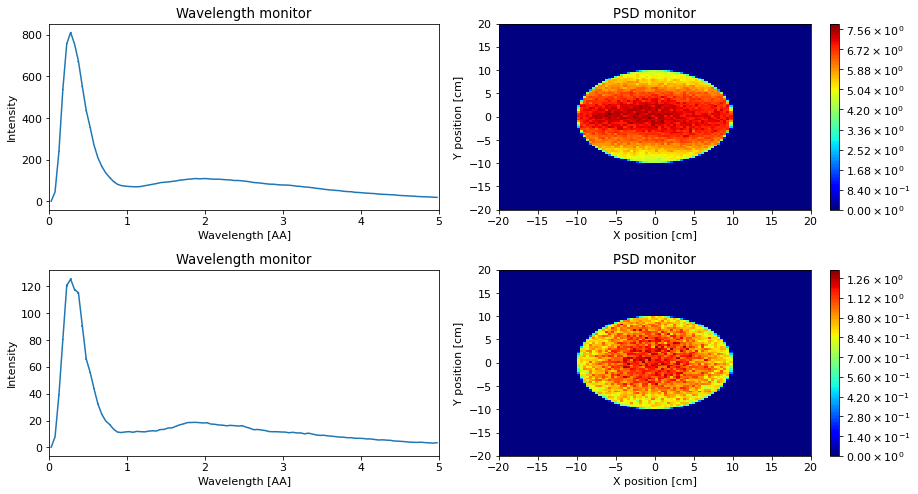

In [8]:
plot = plotter.make_sub_plot(DATA['KDS_resampled_gcc'])

Plotting data with name LMon1
Plotting data with name PSDMon1
Plotting data with name LMon2
Plotting data with name PSDMon2


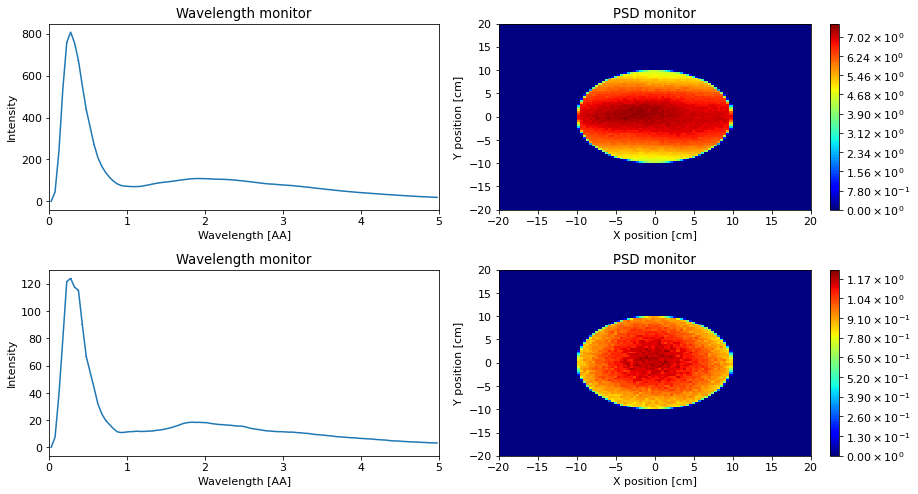

In [9]:
plot = plotter.make_sub_plot(DATA['KDS_old_gcc'])

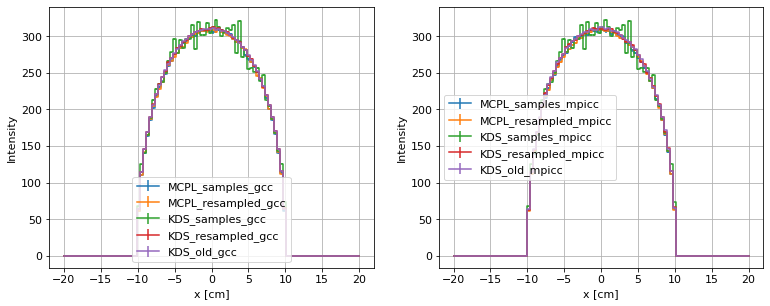

In [10]:
plt.rcParams['figure.figsize']=(6.4*2, 4.8)
for key in DATA.keys():
    if key.find('gcc')!=-1:
        plt.subplot(121)        
    else:
        plt.subplot(122)
    plt.errorbar(np.linspace(-Rmon*100, Rmon*100, 100), np.sum(DATA[key][1].Intensity, axis=0),np.sum(DATA[key][1].Error**2, axis=0)**0.5, label=key, ds='steps-mid')

plt.subplot(121)
plt.legend()
plt.grid()
plt.xlabel('x [cm]')
plt.ylabel('Intensity')

plt.subplot(122)
plt.legend()
plt.grid()
plt.xlabel('x [cm]')
plt.ylabel('Intensity')

plt.show()
plt.rcParams['figure.figsize']=(6.4, 4.8)

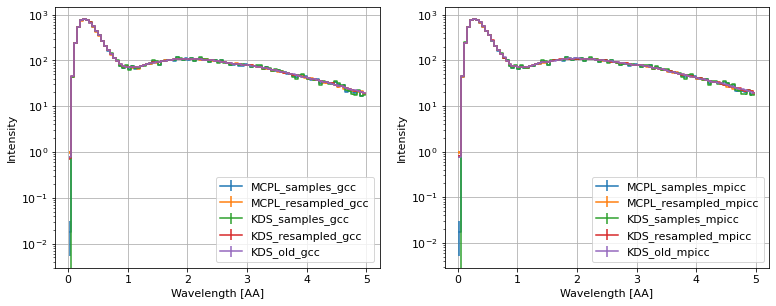

In [11]:
plt.rcParams['figure.figsize']=(6.4*2, 4.8)
for key in DATA.keys():
    if key.find('gcc')!=-1:
        plt.subplot(121)        
    else:
        plt.subplot(122)
    plt.errorbar(DATA[key][0].xaxis, DATA[key][0].Intensity, DATA[key][0].Error, ds='steps-mid', label=key)
plt.subplot(121)
plt.legend()
plt.grid()
plt.yscale('log')
plt.xlabel('Wavelength [AA]')
plt.ylabel('Intensity')

plt.subplot(122)
plt.legend()
plt.grid()
plt.yscale('log')
plt.xlabel('Wavelength [AA]')
plt.ylabel('Intensity')

plt.show()
plt.rcParams['figure.figsize']=(6.4, 4.8)